# Step 7 - Context Generation

This notebook aims to show the results obtained by developing a learner that is able to progressively split between contexts in order to target multiple disaggregated classes. 

This learner employs AlphaUnitless Learners at its core, which use Multi Armed Bandit algorithms implemented via a Gaussian Processes in order to exploit continuity between the different arms. The learner will have a number of AlphaUnitless Learners, one for each context that is currently targeting.
As specified in the assignment the split will be performed on all of the subcampaigns simultaneously and the optimization will be performed on the resulting context-dependant products.

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters, Feature
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import random

plt.style.use('seaborn-v0_8-dark')

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
def compute_regret(rewards, avg_clairvoyant_reward):
    regret = avg_clairvoyant_reward - rewards
    regret[regret<0] = 0
    return np.cumsum(regret)


In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiment(n_days, rewards, avg_clairvoyant_reward, title, time_points=None, reward_color='cornflowerblue', regret_color='salmon'):

    regret_plot = compute_regret(rewards, avg_clairvoyant_reward)
    clairvoyant_plot = np.ones(len(rewards)) * avg_clairvoyant_reward

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

    ax[0].plot(rewards, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} reward')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[1].plot(regret_plot, color=regret_color)
    ax[1].title.set_text(f'{title} regret')
    
    trans_0 = transforms.blended_transform_factory(ax[0].transData, ax[0].transAxes)
    trans_1 = transforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
    if time_points:
        for point, label in time_points:
            ax[0].axvline(x = point, color = 'green', label = None, linestyle=':')
            ax[0].text(x = point - 2, y = 0.2, s = label, size = 10, rotation = 90, color = 'green', transform = trans_0)
            ax[1].axvline(x = point, color = 'green', label = None, linestyle=':')
            ax[1].text(x = point - 2, y = 0.2, s = label, size = 10, rotation = 90, color = 'green', transform = trans_1)
        
    plt.show()

In [4]:
def get_n_features(contexts):
    n_features = list(map(lambda c: (
            len([f[0] for f in c if f[0] == "feature_1"]),
            len([f[0] for f in c if f[0] == "feature_2"]), 
    ), contexts))
    if len(n_features) >= 1:
        n_features = (sum(i for i, j in n_features), sum(j for i, j in n_features))
    else:
        n_features = (0, 0)
    return n_features

def n_contexts_to_label(all_contexts, timestamps):
    labels = []
    for timestamp, contexts in zip(timestamps, all_contexts):
        n_features = get_n_features(contexts)
        labels.append([timestamp, f"#splits on f1: {n_features[0]} - #splits on f2: {n_features[1]}"])
    return labels
        
def avg_contexts_to_label(all_contexts_learners, timestamps):
    n_features = []
    for all_contexts in all_contexts_learners:
        n_features.append([get_n_features(contexts) for contexts in all_contexts])
    n_features = [ 
        (sum(l[i][0] for l in n_features), sum(l[i][1] for l in n_features)) 
        for i in range(len(timestamps)) 
    ]
    labels = []
    for timestamp, n_f in zip(timestamps, n_features):
        labels.append([timestamp, f"#splits on f1: {n_f[0]} - #splits on f2: {n_f[1]}"])
    return labels

### Environment setup
We will run both learners in the same exact environment.

In [5]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.2, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.5, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 80),
                UserClassParameters(20, 0.05, 360),
            ],
            [
                UserClassParameters(33, 0.4, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 300),
                UserClassParameters(36, 0.05, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=400,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[3, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.7, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.05, 0, 0, 0.25, 0],
            ]
        ),
    )
    return env

In [6]:
# Random Number Generator used as a source of randomness by the environment and the simulation
seed = 44
rng = np.random.default_rng(seed)

In [7]:
# Creating the environment
env = make_env(rng)

#### Default parameters

In [8]:
# Simulation separated default parameters
sim_n_days = 50
sim_week_iter = 3
avg_clairvoyant_reward = clairvoyant_reward(env, 800, 400, 20)

## Single contextual learner implementation

In [9]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.FIVE,
    n_budget_steps=20,
    population_mean=800,
    population_variance=10,
    features=[Feature("feature_1", None), Feature("feature_2", None)],
    mab_algorithm=Mab.GPTS,
)

In [10]:
# Running the simulation
split_data = []

for i in range(sim_week_iter):
    simulation.simulate(14)
    split_data.append(simulation.learner.context_generation(simulation.dataset))
    
sim_remaining_days = sim_n_days - sim_week_iter * 14

if sim_remaining_days > 0:
    simulation.simulate(sim_remaining_days)
    
rewards = simulation.rewards
time_points = [14 * i for i in range(sim_week_iter + 1)]
time_labels = n_contexts_to_label([[]] + split_data, time_points)

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/28 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/42 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

### Results

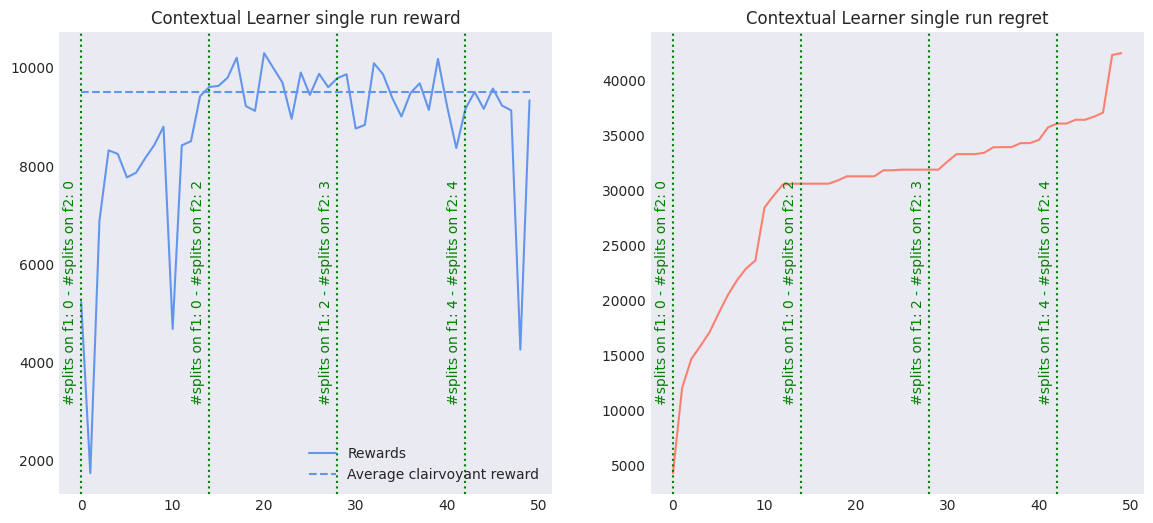

In [11]:
# Plotting the experiment
rewards = simulation.rewards

plot_experiment(
    sim_n_days,
    rewards,
    avg_clairvoyant_reward,
    'Contextual Learner single run',
    time_points = time_labels
)

We can observe as in this particular case we have a better performance than the AlphaUnitLess learner, which the Contextual learner is based on. The green lines represent the context generation algorithm runs (that happen every 14 days) and near them indicates the number of contexts generated from the splits, aggregated by feature.
In this case we reach the maximum number of splits achievable but this result is not guaranteed in a finite amount of days.

# Average Behaviour
Now we compute average reward and regret (including standard deviation) over a significant number of runs.

In [12]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_avg_experiments(n_days, n_rewards, avg_clairvoyant_reward, title, time_points=None, reward_color='cornflowerblue', regret_color='salmon', std_color='salmon'):

    avg_reward = np.average(n_rewards, axis=0)
    std_reward = np.std(n_rewards, axis=0)
    x = np.arange(n_days)

    avg_regret = avg_clairvoyant_reward - avg_reward
    avg_regret[avg_regret<0] = 0
    avg_regret = np.cumsum(avg_regret)
    
    upper_std_regret = avg_clairvoyant_reward - avg_reward + std_reward
    upper_std_regret[upper_std_regret<0] = 0
    upper_std_regret = np.cumsum(upper_std_regret)

    lower_std_regret = avg_clairvoyant_reward - avg_reward - std_reward
    lower_std_regret[lower_std_regret<0] = 0
    lower_std_regret = np.cumsum(lower_std_regret)

    clairvoyant_plot = np.ones(len(avg_reward)) * avg_clairvoyant_reward

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(avg_reward, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} average reward over {len(n_rewards)} experiments')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    print(avg_reward)
    print(std_reward)
    ax[0].fill_between(x, (avg_reward-std_reward), (avg_reward+std_reward), color=std_color, alpha=.1, label= 'std')

    ax[1].plot(avg_regret, color=regret_color)
    ax[1].title.set_text(f'{title} average regret over {len(n_rewards)} experiments')

    ax[1].fill_between(x, lower_std_regret, upper_std_regret, color=std_color, alpha=.1)
    
    trans_0 = transforms.blended_transform_factory(ax[0].transData, ax[0].transAxes)
    trans_1 = transforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
    if time_points:
        for point, label in time_points:
            ax[0].axvline(x = point, color = 'green', label = None, linestyle=':')
            ax[0].text(x = point - 2, y = 0.2, s = label, size = 10, rotation = 90, color = 'green', transform = trans_0)
            ax[1].axvline(x = point, color = 'green', label = None, linestyle=':')
            ax[1].text(x = point - 2, y = 0.2, s = label, size = 10, rotation = 90, color = 'green', transform = trans_1)
        
    plt.show()

In [13]:
rng = np.random.default_rng(seed)
env = make_env(rng)

In [14]:
sim_n_experiments = 10
sim_week_iter = 3
sim_n_days = 50
seed = 44

# Creating multiple simulations
simulations = create_n(
    rng,
    env,
    step=Step.FIVE,
    n=sim_n_experiments,
    n_budget_steps=20,
    population_mean=800,
    population_variance=10,
    features=[Feature("feature_1", None), Feature("feature_2", None)],
    mab_algorithm=Mab.GPTS,
)

In [15]:
split_data = [[] for i in range(sim_n_experiments)]

for i in range(sim_week_iter):
    rewards = simulate_n(simulations, 14)
    for split, sim in zip(split_data, simulations):
        split.append(sim.learner.context_generation(simulation.dataset))
        
sim_remaining_days = sim_n_days - sim_week_iter * 14

if sim_remaining_days > 0:
    rewards = simulate_n(simulations, sim_remaining_days)

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days: 0it [00:00, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

days:   0%|          | 0/8 [00:00<?, ?it/s]

[array([5232., 1749., 6887., 8316., 8243., 7765., 7861., 8156., 8426.,
       8896., 8747., 8530., 9169., 9269., 8423., 9395., 9150., 8538.,
       8189., 8558., 8280., 8760., 8679., 8584., 8353., 8769., 8604.,
       8583., 9376., 8712., 9256., 9664., 8985., 9742., 9162., 9648.,
       8771., 8466., 9355., 8882., 8878., 8786., 8983., 8524., 9339.,
       8661., 9439., 9192., 9369., 8889.]), array([ 6035.,  2194.,  4992.,  6464.,  7103.,  4812.,  7485.,  8231.,
        7774.,  9379.,  8238.,  8866.,  8737.,  9148.,  6979.,  7670.,
        7569.,  7751.,  7480.,  7678.,  7336.,  7271.,  8111.,  7099.,
        7112.,  7180.,  7740.,  7136.,  8616.,  7556.,  8182.,  8807.,
        9081.,  9273.,  9710.,  9146.,  8834.,  9113.,  8646.,  9080.,
        8907.,  9731.,  9293.,  9391.,  9934.,  9693., 10066.,  9703.,
        9806.,  9667.]), array([9376., 6852., 4406., 6161., 9486., 9482., 9389., 9083., 9515.,
       4174., 9473., 9513., 9225., 3505., 9288., 8800., 9352., 9066.,
       9915., 

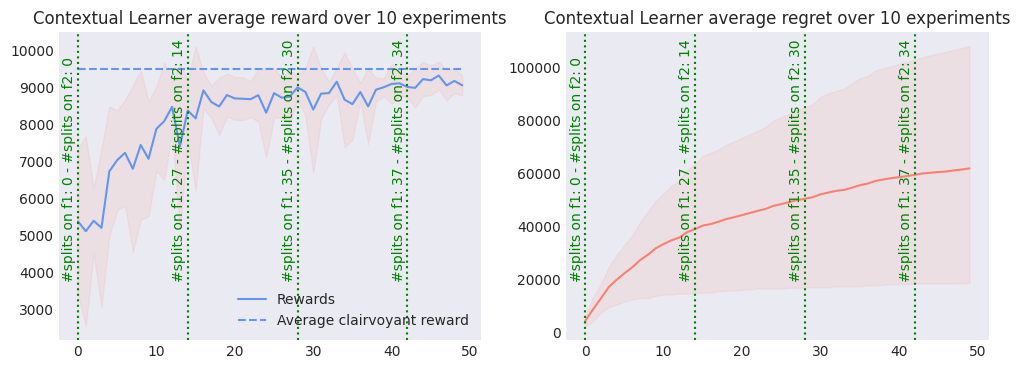

In [16]:
offset_split = []
for split in split_data:
    offset_split.append([[]] + split)
time_points = [14 * i for i in range(sim_week_iter + 1)]
time_labels = avg_contexts_to_label(offset_split, time_points)

print(rewards)
plot_avg_experiments(sim_n_days, 
    rewards,
    avg_clairvoyant_reward, 
    'Contextual Learner',
    time_points = time_labels
)

In [17]:
# Computing empiric regret
avg = np.average(rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clairvoyant_reward * sim_n_days - total_rew

# Computing average statistics a time T
avg_reward = np.average(rewards, axis=0)
avg_reward_T = avg_reward[-1]
std_reward_T = np.std(rewards, axis=0)[-1]
avg_regret = avg_clairvoyant_reward - avg_reward
avg_regret[avg_regret<0] = 0
avg_regret_T = np.cumsum(avg_regret)[-1]

print(f'Contextual learner empiric regret over a {sim_n_days} days horizon: {empiric_regret}')
print(f'Contextual learner average reward at {sim_n_days} days: {avg_reward_T}')
print(f'Contextual learner average devstandard at {sim_n_days} days: {std_reward_T}')
print(f'Contextual learner average regret over a {sim_n_days} days: {avg_regret_T}')

Contextual learner empiric regret over a 50 days horizon: 61719.20000000001
Contextual learner average reward at 50 days: 9065.3
Contextual learner average devstandard at 50 days: 273.6698923886221
Contextual learner average regret over a 50 days: 61719.2
